<a href="https://colab.research.google.com/github/EskelinenElias/ADAML-project1/blob/main/data_modeling_plan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADAML Project Work: Intermediary Submission 2 - Data Modeling Plan

LUT University \
BM20A6100 Advanced Data Analysis and Machine Learning - Blended teaching, Lpr 1.9.2025-12.12.2025 \
1st Period - Project work - Intermediary Submission 2 - Data modeling plan

Elias Eskelinen, Vili Niemelä & Matti Aalto \
25.9.2025

---

## Intermediary Submission 2 - Instructions

Based on your initial evaluation, the received feedback and the strategies of other groups, perform data pretreatment. There will be a max. 2 pages addition to your project PDF for the pretreatment part.

Breakdown of the points:

0.5p   - feedback incorporation and adjustment of the initial pretreatment plan
0.5p  - data centering and scaling techniques
0.5p  - evaluation of extreme/ missing values and mitigating actions, data synchronization (for time series), sampling
0.5p   - visualizing pretreated data
Modelling plan

Make a modelling plan for your modelling goal. Create a flowchart of the operations needed to accomplish the task, and assign roles to the team members for each step. The start of each flow chart should be the cleaned data, and the end of it should be the modelling goal achieved. If there is more than one modelling goal, the flowchart can take multiple paths. There will be a max. 2 pages addition to your project PDF for the modelling plan part.

0.5p     - modelling goal (What is the purpose of your data analysis?);
0.5p     - model calibration strategy: tools used, methodology, data used;
0.5p     - model validation strategy: scope of validation, methodology;
0.5p     - model testing strategy: metrics and data used;
0.5p     - description of the mathematical methods used in modelling;
0.5p     - model diagram/ operations flowchart.


## Initialization

Set random number state for reproducibility: 

In [79]:
import numpy as np

np.random.seed(42)

figs_dir = "figures"

## Data onboarding

Fetch data from kaggle:

In [80]:
import kagglehub
import os

# Fetch the latest version of the dataset from kaggle
data_dir = kagglehub.dataset_download("edumagalhaes/quality-prediction-in-a-mining-process")

data_path = os.path.join(data_dir, os.listdir(data_dir)[0])
print("Path to dataset files:", data_path)

Path to dataset files: /Users/eliaseskelinen/.cache/kagglehub/datasets/edumagalhaes/quality-prediction-in-a-mining-process/versions/1/MiningProcess_Flotation_Plant_Database.csv


Loading the data

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(data_path)

Formatting the data

In [82]:
# Format date column as dates
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

# Format other columns as decimal numbers
for c in data.columns[1:]: data[c] = data[c].str.replace(',', '.').astype(float)

Check data size and shape

In [83]:
print(data.shape)

(737453, 24)


## Data pretreatment

Resampling the data

In [84]:
# Resample the data to 1 hour frequency
data = data.groupby("date").mean(numeric_only=True).reset_index()

Normalizing the data

In [85]:
numerical_cols = data[data.columns[1:]] # Normalize all columns except the date column

means = numerical_cols.mean()
stds = numerical_cols.std()

data[data.columns[1:]] = (numerical_cols - means) / stds

## PCA 

Split the data into training and test data

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Dataset without the date column
PCA_data = data[data.columns[1:]]

# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

Fitting the PCA model

In [87]:
# Dataset without the date column
PCA_data = data[data.columns[1:]]

# Set the number of components 
num_components = len(PCA_data) 

# Fit the PCA model
pca = PCA()
pca.fit(PCA_data)

PCA()

Visualizing the singular values

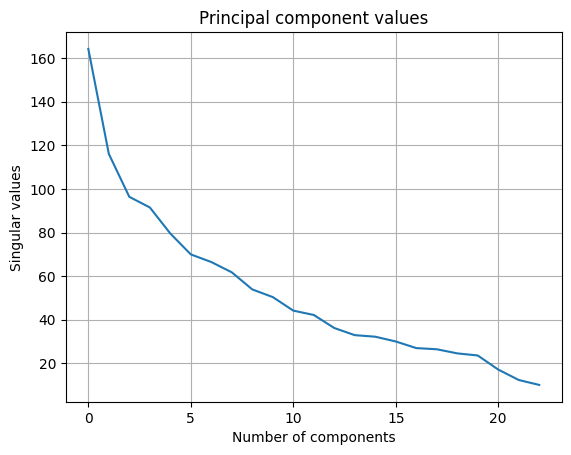

In [88]:
plt.figure()
plt.plot(pca.singular_values_)
plt.xlabel('Number of components')
plt.ylabel('Singular values')
plt.grid()
plt.title("Principal component values")
plt.savefig(os.path.join(figs_dir, "PCA_singular_values.png"))
plt.show()


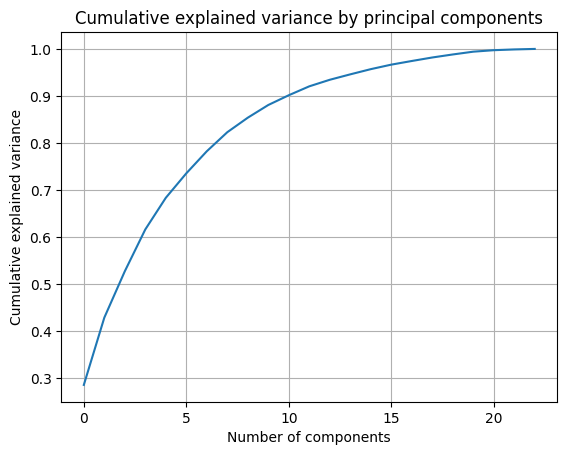

In [89]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.title("Cumulative explained variance by principal components")
plt.savefig(os.path.join(figs_dir, "PCA_cumulative_explained_variance.png"))
plt.show()